In [84]:
import misleep
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import datetime 
from misleep import second2time

In [18]:
data = misleep.load_mat(r'E:\workplace\EEGProcessing\00_DATA\LYT_20240612_070354\mouse4\mouse4.mat')
anno = misleep.load_misleep_anno(r'E:\workplace\EEGProcessing\00_DATA\LYT_20240612_070354\mouse4\mouse4.txt')

In [30]:
data.channels

['EEG_1', 'EEG_2', 'EMG_1', 'EMG_2', 'EMG_DIFF', 'REF']

In [93]:
# only do cluster in the previous 40000 seconds, or the data is too large

F_4s_group = [data.signals[0][int(sec*data.sf[0]): int(sec*data.sf[0])+int(4*data.sf[0])] 
              for sec in range(0, data.duration-4, 4)]
P_4s_group = [data.signals[1][int(sec*data.sf[1]): int(sec*data.sf[1])+int(4*data.sf[1])]
              for sec in range(0, data.duration-4, 4)]

EMG_4s_group = [data.signals[4][int(sec*data.sf[4]): int(sec*data.sf[4])+int(4*data.sf[4])]
              for sec in range(0, data.duration-4, 4)]

# Convert the lists to numpy arrays
F_4s_group = np.array(F_4s_group)
P_4s_group = np.array(P_4s_group)
EMG_4s_group = np.array(EMG_4s_group)

In [94]:
# Feature extraction, here for EEG we only consider the delta power, theta power, alpha power
# For EMG, we consider the Mean and Std

# Step 1: Normalize the data
scaler = StandardScaler()
F_4s_group_norm = scaler.fit_transform(F_4s_group)
EMG_4s_group_norm = scaler.fit_transform(EMG_4s_group)

# Step 2: Feature Extraction 
F_freq_psd = [misleep.spectrum(signal, data.sf[0], relative=False, win_sec=1) for signal in F_4s_group_norm]
F_power_ = np.array([list(misleep.band_power(
    each[1], each[0], 
    bands=[[0.5, 4, 'delta'], [4, 9, 'theta'], [8, 12, 'alpha']], 
    relative=True).values()) for each in F_freq_psd])
TD_ratio = np.array([[each[1]/each[0]] for each in F_power_])
EMG_mean_ = np.mean(EMG_4s_group_norm, axis=1).reshape(-1, 1)
EMG_std_ = np.std(EMG_4s_group_norm, axis=1).reshape(-1, 1)
features = np.hstack((TD_ratio, EMG_std_))

d:\miniconda3\envs\EEG\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Silhouette Score: 0.5074150108149857


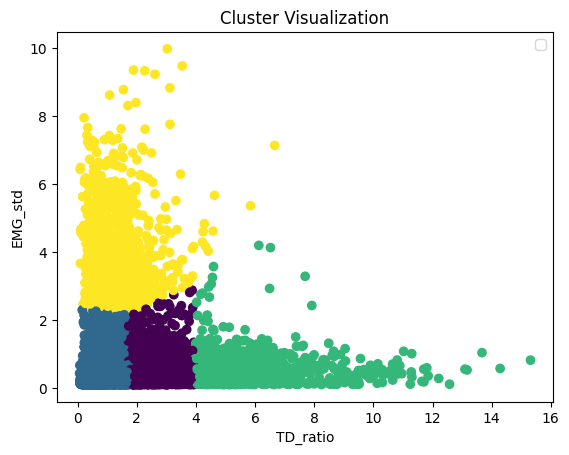

In [95]:
# Step 4: Clustering
kmeans = KMeans(n_clusters=4)  # Choose an appropriate number of clusters
clusters = kmeans.fit_predict(features)

# Step 5: Evaluation
sil_score = silhouette_score(features, clusters)
print(f'Silhouette Score: {sil_score}')

# Optional: Visualization
plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('TD_ratio')
plt.ylabel('EMG_std')
plt.legend()
plt.show()

In [96]:
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[0 1 1 ... 1 1 1]
[[2.52977822 0.53401913]
 [0.95153414 0.41086817]
 [5.41566649 0.5339768 ]
 [1.32284562 4.05329047]]


In [107]:
sleep_state = kmeans.labels_
kmeans_dict = {0: 'IS', 1: 'NREM', 2: 'REM', 3: 'Wake'}
sleep_state = [kmeans_dict[each] for each in sleep_state]
revert_state_map = {
                'NREM': 1,
                'REM': 2,
                'Wake': 3,
                'Init': 4,
                'MicroArousal': 5,
                'IS': 6
            }

sleep_state = [revert_state_map[each] for each in sleep_state]

In [108]:
sleep_state = [[each]*4 for each in sleep_state]
sleep_state = [item for each in sleep_state for item in each]

In [109]:
len(sleep_state)

86488

In [110]:
state_map = {
                1: 'NREM',
                2: 'REM',
                3: 'Wake',
                4: 'Init',
                5: 'MicroArousal',
                6: 'IS'
            }
ac_time = datetime.datetime.strptime("20240612-07:03:57", "%Y%m%d-%H:%M:%S")
marker = []

start_end_label = []

sleep_state = misleep.lst2group([[idx, each] for idx, each in enumerate(sleep_state)])

sleep_state = [', '.join([
    second2time(each[0], ac_time=ac_time), str(each[0]), '1',
    second2time(each[1], ac_time=ac_time), str(each[1]),
    '0', str(each[2]), state_map[each[2]]
]) for each in sleep_state]

if len(marker) > 0:
    marker = [''] + marker
if len(start_end_label) > 0:
    start_end_label = [''] + start_end_label

annos = [
    "READ ONLY! DO NOT EDIT!\n4-INIT 3-Wake 2-REM 1-NREM",
    "Save time: " + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 
    "Acquisition time: " + ac_time.strftime("%Y-%m-%d %H:%M:%S"),
    "==========Marker==========" + '\n'.join(marker),
    "==========Start-End==========" + '\n'.join(start_end_label),
    "==========Sleep stage==========", '\n'.join(sleep_state)
]

with open(r'E:\workplace\EEGProcessing\00_DATA\LYT_20240612_070354\mouse4\mouse4_cluster.txt', 'w') as f:
    f.write('\n'.join(annos))